<a href="https://colab.research.google.com/github/KunjParikh/cmpe256/blob/master/HWs/CMPE256_RecSys_I_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (40%) Collaboraitve Filtering Movie Recommendation

In [0]:
#Need this cell only for google colab envt.
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s gdrive/'My Drive'/SJSU/'large scale analytics'/HWs gdata
!pip install requests
!pip install python-firebase

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
  Stored in directory: /root/.cache/pip/wheels/ba/40/ca/e41a25d7abb787092e837cb0f91f33b04b1a8fd9d17c2d33a6
Successfully built python-firebase


In [0]:
#Modules used.
import pandas as pd
import numpy as np

In [0]:
#A Dictionary of movie critics and their ratings of a small set of movies
critics={
  'Lisa Rose': {
    'Lady in the Water': 2.5, 
    'Snakes on a Plane': 3.5,
    'Just My Luck': 3.0, 
    'Superman Returns': 3.5, 
    'You, Me and Dupree': 2.5,
    'The Night Listener': 3.0
  },
  'Gene Seymour': {
    'Lady in the Water': 3.0, 
    'Snakes on a Plane': 3.5,
    'Just My Luck': 1.5, 
    'Superman Returns': 5.0, 
    'The Night Listener': 3.0,
    'You, Me and Dupree': 3.5
  },
  'Michael Phillips': {
    'Lady in the Water': 2.5, 
    'Snakes on a Plane': 3.0,
    'Superman Returns': 3.5, 
    'The Night Listener': 4.0
  },
  'Claudia Puig': {
    'Snakes on a Plane': 3.5, 
    'Just My Luck': 3.0,
    'The Night Listener': 4.5, 
    'Superman Returns': 4.0,
    'You, Me and Dupree': 2.5
  },
  'Mick LaSalle': {
    'Lady in the Water': 3.0, 
    'Snakes on a Plane': 4.0,
    'Just My Luck': 2.0, 
    'Superman Returns': 3.0, 
    'The Night Listener': 3.0,
    'You, Me and Dupree': 2.0
  },
  'Jack Matthews': {
    'Lady in the Water': 3.0, 
    'Snakes on a Plane': 4.0,
    'The Night Listener': 3.0, 
    'Superman Returns': 5.0, 
    'You, Me and Dupree': 3.5
  },
  'Toby': {
    'Snakes on a Plane':4.5,
    'You, Me and Dupree':1.0,
    'Superman Returns':4.0
  }
}

### Suppose we are given a data set above of each customrs' rating to each movie with sacle 0-5. Stored as python dictinary format. Can you write a function with inputs of rating data and two persons, return their similarity measured by Pearson correlation. You may define and implment other similarity measure also. (10%). 

#### Solutions

Pearson coefficient similarity : 


In [0]:
def processDict(dict):
  df = pd.DataFrame.from_dict(dict)
  #critics_df = critics_df.fillna(0.0) #Don't do this!!!! NaN is handled correclty for mean.
  df = df.transpose()
  return df

critics_df = processDict(critics)
critics_df

,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
Lisa Rose,3.0,2.5,3.5,3.5,3.0,2.5
Gene Seymour,1.5,3.0,3.5,5.0,3.0,3.5
Michael Phillips,NaN,2.5,3.0,3.5,4.0,NaN
Claudia Puig,3.0,NaN,3.5,4.0,4.5,2.5
Mick LaSalle,2.0,3.0,4.0,3.0,3.0,2.0
Jack Matthews,NaN,3.0,4.0,5.0,3.0,3.5
Toby,NaN,NaN,4.5,4.0,NaN,1.0


In [0]:
#Substract mean from each row.
def similarity(df, p1, p2):
  df = df.sub(df.mean(axis=1), axis=0) #Remove mean rating for similarity.
  #After removing mean we can replace NaN with 0.
  df = df.fillna(0.0)
  p1 = df.loc[p1].values
  p2 = df.loc[p2].values
  numerator = np.dot(p1, p2)
  denominator = np.sqrt(np.dot(p1, p1) * np.dot(p2, p2))
  return numerator / denominator
  

similarity(critics_df, 'Lisa Rose',  'Toby')

0.8093446482740976

### Given a person, say A, could you write a function to return top n persons most similar to A (exclude A) (5%)? 
### Same dataset as above.

#### Solutions

In [0]:
#Similarity matrix
def similarityMatrix(df):
  sim_mat = pd.DataFrame(index=df.index.values, columns=df.index.values)
  for p1 in sim_mat.index.values:
    for p2 in sim_mat.columns.values:
      sim_mat[p1][p2] = similarity(df, p1, p2)
  return sim_mat

def mostSimilar(df, person, num):
  sim_mat = similarityMatrix(df)
  #Series and sorted descending
  sims = sim_mat[person].sort_values(ascending = False)
  #Get Series labels and return ndarray
  return sims.index[1:num+1].values

mostSimilar(critics_df, 'Lisa Rose', 2)

array(['Toby', 'Jack Matthews'], dtype=object)

### Given a person, say A, could you write a function to recommend those unseen movies? (10%)

#### Solutions

In [0]:
#Use Prediction formula from class. pred = ra' + sum(sim*(rpb - rb'))/sum(sim)
#We already have means removed from rating.. so its just ra' + sum(sim*rb)/sum(sim)
def prediction(df, person, movie):
  simMat = similarityMatrix(df)
  personAverage = df.mean(axis=1).loc[person]
  similarities= simMat.loc[person].values
  #Replace NaN with 0.0 to ignore them in num. 
  #To ignore them in deno create flag.
  ratings = df[:][movie].fillna(0.0).values
  flag = np.array([1 if x>0 else 0 for x in ratings])
  numerator = np.dot(similarities, ratings)
  denominator = np.dot(similarities, flag)
  return personAverage + (numerator / denominator)

#Return cmpNum movies
def suggest(df, person, cmpNum=1):
  
  notWatchedMovies = df.loc[person] #Next Filter on Series
  notWatchedMovies = notWatchedMovies[notWatchedMovies.isnull()].index.values
  
  pred_rating = pd.Series(index = notWatchedMovies)
  for movie in notWatchedMovies:
    pred_rating[movie] = prediction(df, person, movie)
    
  watchThese = pred_rating.sort_values(ascending = False).index.values
  print("Watch these movies, first one first: {}".format(watchThese))
  return watchThese

#prediction(critics_df, 'Toby', 'Just My Luck')
suggest(critics_df, 'Toby')

Watch these movies, first one first: ['The Night Listener' 'Lady in the Water' 'Just My Luck']


array(['The Night Listener', 'Lady in the Water', 'Just My Luck'],
      dtype=object)

### Let's using another approach, can you write a function to return top n most similair movies for a given movie? (5%) 

#### Solutions

In [0]:
movie_df = critics_df.transpose()
movie_df

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Just My Luck,3.0,1.5,NaN,3.0,2.0,NaN,NaN
Lady in the Water,2.5,3.0,2.5,NaN,3.0,3.0,NaN
Snakes on a Plane,3.5,3.5,3.0,3.5,4.0,4.0,4.5
Superman Returns,3.5,5.0,3.5,4.0,3.0,5.0,4.0
The Night Listener,3.0,3.0,4.0,4.5,3.0,3.0,NaN
"You, Me and Dupree",2.5,3.5,NaN,2.5,2.0,3.5,1.0


In [0]:
#The same similarity, and mostSimilar works with transpose as input.
mostSimilar(movie_df, 'Just My Luck', 2)

array(['The Night Listener', 'Snakes on a Plane'], dtype=object)

### Given a movie, say B, could you write a function to recommend those peoples who have not seen this movies but they may rank this movie with high score? For example, who are those two persons who will rate "Just My Luck" high but they never seen this movie before? (10%)

#### Solutions

In [0]:
def suggest2(df, movie, numSuggest=2):
  pNotWatched = df.loc[movie]
  pNotWatched = pNotWatched[pNotWatched.isnull()].index.values
  
  #We can use same prediction function.. as we still go by similarity of person 
  pred_rating = pd.Series(index = pNotWatched)
  for person in pNotWatched:
    pred_rating[person] = prediction(df.transpose(), person, movie)
    
  watchThese = pred_rating.sort_values(ascending = False).index.values
  return watchThese[0:numSuggest]


suggest2(movie_df, 'Just My Luck')

array(['Michael Phillips', 'Jack Matthews'], dtype=object)

### (20%) Data Preparation

### 1. Data quality can be assessed in terms of accuracy, completeness, and consistency. What other factors are also important to data quality (5%)? 

#### Solutions


- Accuracy : The degree to which data correctly describes the "real world" object or event
being described.
- Completeness : The proportion of stored data against the potential of “100%
complete”
- Consistency : The absence of difference, when comparing two or more representations of a
thing against a definition
- Uniqueness : Nothing will be recorded more than once based upon how that thing is
identified. It is the inverse of an assessment of the level of duplication
- Timeliness : The degree to which data represent reality from the required point in time
- Validity : Data are valid if it conforms to the syntax (format, type, range) of its definition

### 2.  Suppose that the data for analysis includes the attribute age. The age values for the data tuples are (in increasing order) 13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70  (10%).

(a) What is the mean of the data? What is the median?

(b) What is the mode of the data? Comment on the data's modality (i.e., bimodal, trimodal, etc.).

(c) What is the midrange of the data?

(d) Can you find (roughly) the first quartile (Q1) and the third uartile (Q3) of the data? 

(e) Give the five-number summary, minimum, Q1, median, Q3, maximum, of the data.

(f) Show a boxplot of the data from (e).

(g) How is a quantile-quantile plot different from a quantile plot? (The quantile-quantile (q-q) plot is a graphical technique for determining if two data sets come from populations with a common distribution.  A q-q plot is a plot of the quantiles of the first data set against the quantiles of the second data set.)

#### Solution


Length of the data is 27
Mean is 29.962962962962962, Median is 25.0.
Modes are [25 35], modality is 2
Midrange is 41.5
First quartile Q1 is 20, third quartile Q3 is 35
Summary of data: minimum=13, Q1=20, median=25.0, Q3=35, maximum=70
Box plot showing the summary.


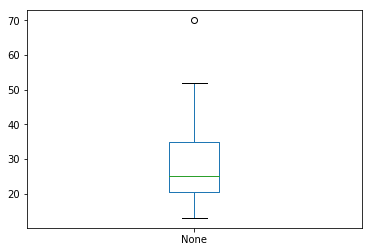

In [0]:
data = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25 ,25 ,25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]
data = pd.Series(data)
print("Length of the data is {}".format(len(data)))
print("Mean is {}, Median is {}.".format(data.mean(), data.median()))
print("Modes are {}, modality is {}".format(data.mode().values, len(data.mode().values)))
#Bimodal in this testcase.
print("Midrange is {}".format((data.iloc[0] + data.iloc[-1])/2.0))
print("First quartile Q1 is {}, third quartile Q3 is {}".format(
  data.quantile(.25, interpolation='nearest'), 
  data.quantile(.75, interpolation='nearest')))
print("Summary of data: minimum={}, Q1={}, median={}, Q3={}, maximum={}".format(
  data.min(), 
  data.quantile(.25, interpolation='nearest'),
  data.median(),
  data.quantile(.75, interpolation='nearest'),
  data.max()))

#Note that this shows upper whisker till 52, and 70 is detected as outlier.
print("Box plot showing the summary.")
data.plot.box()

### 3. In practical data, tuples with missing values for some attributes are a common occurrence. Describe various methods for handling this problem (5%) .

#### Solutions


- Ignore the tuple when class value is missing.
- Manually fill in missing values.
- Use global constant to replace missing values. Say NaN, -inf, etc.
- Using mean of quantitative values. Mode for categorical values. 
- Using mean and mode for all samples belonging to same class as given tuple.
- Fill using most probable value determined by regresion, inference , Bayesian, DT etc.

## (30%) How to Acquire & Refine the Data


## Items, Users, Signal

- **Items**: Objects to be recommended
- **Users**: Target of the recommendation
- **Signal**: Explicit or Implicit feedback between Items and users

In our context
- Items are **stories** posted on HN
- Users are **users** commenting or posting stories
- Signal are **comments** on the stories by the user signalling interest

## Source of Data 

Lets see the sources for getting historical information posted on HackerNews

- **HackerNews API** - YCombinator provides an official hackernew api through Firebase. This is a near real-time database and provides both an *items* (stories and comments) as well as an *users* api.  It is available at https://github.com/HackerNews/API

- **BigQuery** : Google Big Query has a daily updated HackerNews public dataset available (from 2006 to date). It only has *items* information. It is available at https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.full

## Items (Stories) 

The schema for the Big Query table is

| Field       | Type      | Description                           |
|:------------|----------:|:--------------------------------------|
| by          | STRING    | The username of the item's author.    |
| score       | INTEGER   | Story score                           |
| time        | INTEGER   | Unix time                             |
| timestamp   | TIMESTAMP | Timestamp for the unix time           |
| title       | STRING    | Story title                           |
| type        | STRING    | Type of details (comment, story, ...) |
| url         | STRING    | Story url                             |
| text        | STRING    | Story or comment text                 |
| parent      | INTEGER   | Parent comment ID                     |
| deleted     | BOOLEAN   | Is deleted?                           |
| dead        | BOOLEAN   | Is dead?                              |
| descendants | INTEGER   | Number of story or poll descendants   |
| id          | INTEGER   | The item's unique id.                 |
| ranking     | INTEGER   | Comment ranking                       |


- Get all the stories posted on HackerNews in **2017 (till date)**. 
- To ensure a relevant set, we will limit the stories which have atleast have **score of 5 points or more** on them. 

This dataset is available in `stories2017score5.gzip`

### Could you read file stories2017score5.csv.gzip by Python pandas package and plot histogram of scores(10%) 

#### Solutions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f2cd71ac8>]],
      dtype=object)

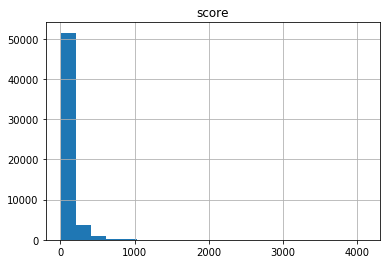

In [0]:
stories = pd.read_csv('gdata/stories2017score5.csv.gzip', compression='gzip', header=0, sep=',', quotechar='"')
stories.hist(column='score', bins=20)

### Most Popular Stories (5%)

For this exercise:
- Let us choose the most popular stories with a score > 500 over the last year
- Lets keep the columns - user (by), userId (id), score (score), title (title)


#### Solutions

In [0]:
top500 = stories[stories['score']>500]
top500 = top500[['by', 'id', 'score', 'title']]
top500.head()
top500.sample(5)

,by,id,score,title
52252,davidcornu,15368104,633,"Draggable JS – a lightweight, responsive, mode..."
33176,v3ss0n,13421608,948,RethinkDB Postmortem
27051,mathgenius,14338411,620,Why do many math books have so much detail and...
40469,vladikoff,15800676,3001,macOS High Sierra: Anyone can login as “root” ...
53100,ingve,15270189,527,Discover the world of microcontrollers through...


###  Item (Story) - User - Signal (Comment) Lets get all the comments from the database by reviewing fifle (bycomments2017score5.csv.gz) and keep only the user and story information. Please see what problems in data and dealing with them. Show me processed data shapes (how many rows and column) and first five rows of  processed data (5%).




#### Solutions

In [0]:
comments = pd.read_csv('gdata/bycomments2017score5.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
comments.dropna(inplace = True)
print("Shape of the data is: {}".format(comments.shape))
print("First 5 rows are below")
comments.head()

#Parent is the story ID. It can be used as below.
#stories[stories['id'] == comments.iloc[0]['parent']]

Shape of the data is: (436347, 2)
First 5 rows are below


,by,parent
13153,05,15878548
13154,0a,13850516
13155,1k,15783427
13156,1k,14602595
13157,21,14192353


### Users information (10%). 

We need to get the details for all the users that have made comments in our list of stories.

Also, we are interested in their details
- How long have they been on the HN platform? (Created)
- How active they are? (# of comments)?
- How good they are to the HN community (karma)?

We will need to get the User Information from HN

- **Hacker News API**: Official API hosted on Firebase - https://github.com/HackerNews/API
- **Haxor**: Unofficial HN Python API c- https://github.com/avinassh/haxor
- **Ascynio-HN**: A very fast async Python API for HackerNews - https://github.com/itielshwartz/asyncio-hn

### Think how you use API to get all uses data information. Download them and save them. Will be used later.

#### Solutions

In [0]:
from firebase import firebase
firebase = firebase.FirebaseApplication('https://hacker-news.firebaseio.com/v0/', None)
result = firebase.get('user/', '05')
print(result)

{'created': 1433941859, 'id': '05', 'karma': 272, 'submitted': [20210674, 20202827, 20094158, 20088297, 19938169, 19699372, 19655308, 19638903, 19638845, 19628591, 19485954, 19464424, 19458482, 19440819, 19355122, 19342832, 19330149, 19310030, 19309012, 19262359, 19262122, 19247523, 19243861, 19243321, 19242209, 19184896, 19172939, 18996837, 18963696, 18963585, 18813684, 18812975, 18812887, 18795261, 18765627, 18740906, 18691405, 18611002, 18437833, 18115978, 17973604, 17925146, 17890909, 17719810, 17615533, 17536369, 17493469, 17492823, 17142203, 16963001, 16948294, 16874824, 16874795, 16869259, 16792469, 16742473, 16733225, 16710387, 16686605, 16661158, 16661085, 16661044, 16660658, 16636705, 16537266, 16400417, 16292110, 16292049, 16260139, 16240033, 16190159, 16146330, 16039883, 16039786, 15880963, 15719844, 15637491, 15624527, 15574294, 15571306, 15016247, 14709934, 14664665, 14646227, 14523814, 14218075, 13474239, 13257369, 13230926, 13029854, 12085215, 11975751, 11952300, 118873

In [0]:
users = pd.DataFrame(columns=['user', 'created', 'numComments', 'karma'])

#This takes ~4 hours to run. Generates hw1_users.csv.gz file.

#for user in comments['by'].unique():
#  result = firebase.get('user/', user)
#  created = result.get('created', 0)
#  numComments = len(result.get('submitted', []))
#  karma = result.get('karma', 0)
  
#  users = users.append({'user': user, 
#                        'created': created, 
#                        'numComments': numComments,
#                        'karma': karma}, ignore_index=True)

#users.to_csv('gdata/hw1_users.csv.gz', compression='gzip')


In [0]:
#loading pre-saved data of above cell.
commentsHN = pd.read_csv('gdata/hw1_users.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
commentsHN.head()

,Unnamed: 0,user,created,numComments,karma
0,0,05,1433941859,148,272
1,1,0a,1477215580,1,3
2,2,1k,1494221943,30,53
3,3,21,1454365382,1705,5141
4,4,2m,1416411507,3,9


## (30%) Feature Engineering (Data Transform)

How do we create the user-item matrix for the HackerNews Dataset
- OneHot Encoding
- Sparse Matrix (for scalability)

### What is OneHot Encoding and its purpose (5%). Could you apply OneHot to encode previous obtained story user comment data from bycomments2017score5.csv.gz ? Show encoded data previous few rows. (10%)

#### Solutions:



A one hot encoding is a representation of categorical variables as binary vectors.

This first requires that the categorical values be mapped to integer values.

Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

In [0]:
#Try on first 1000 else it exceed RAM usage.
comments = comments.head(1000) 
from sklearn.preprocessing import OneHotEncoder
# binary encode
user_encoder = OneHotEncoder(sparse=False)
user_encoded = user_encoder.fit_transform(comments['by'].values.reshape(-1, 1))
comment_encoder = OneHotEncoder(sparse=False, categories='auto')
comment_encoded = comment_encoder.fit_transform(comments['parent'].values.reshape(-1, 1))

In [0]:
#Copy dataframe and replace by with one-hot-encoded value.
#Here I have applied one-hot encoding to both user(by) and commentId(parent)..
comments_enc = comments.head(1000).copy(deep=True)
comments_enc['parent'] = comments_enc['parent'].astype(object)
iter = 0
for i, row in comments_enc.iterrows():
  comments_enc.at[i,'by'] = user_encoded[iter]
  #comments_enc.at[i,'parent'] = comment_encoded[iter]
  iter = iter + 1

In [0]:
comments_enc.head()

,by,parent
13153,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13154,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13155,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13156,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13157,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Could you what is Coordinate list (COO) compression format for sparse matrix generation (5%)
### Implment this to compress previous obtained story user comment data from bycomments2017score5.csv.gz (10%).

#### Solutions



Sparse matrix is an efficient way to store matrix with lots of zero values, and relatively low number of NNZ (non-zero) values. It stores only non-zero value (all 1 in our case for one-hot encoding), and pointer to each non-zero value. 
CSR (Compressed sparse row),  CSC(Compressed sparse column), COO(Coordinate list) are different formats of sparse representation. 

Matrix operations like addition, multiplication, etc can be done directly on sparse representation.

In [0]:
from scipy.sparse import coo_matrix
user_coo = coo_matrix(user_encoded)
comment_coo = coo_matrix(comment_encoded)

#The user is in sparse format now.
user_coo

<1000x86 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in COOrdinate format>

In [0]:
#Copy dataframe and replace by with one-hot-encoded value.
#comments_coo = comments_enc.copy(deep=True)
#iter = 0
#for i, row in comments_enc.iterrows():
#  comments_coo.at[i,'by'] = user_coo[iter]
#  comments_coo.at[i,'parent'] = comment_coo[iter]
#  iter = iter + 1